# ***Implementation of DINOv2-style Self-Supervised Learning Plastic Object Detection from Seashore using YOLOv12 backbone***

# Setup

In [1]:
!pip -q install ultralytics timm tqdm pillow 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00


In [2]:
import os, json, yaml, math, gc, random, shutil, contextlib
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# Dataset Path

In [3]:

BASE  = Path("/kaggle/input/plastic-coco/plastic_coco")
WORK  = Path("/kaggle/working/plastic_coco_ssl_yolov12_dinov2")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_plastic_coco.yaml"
SSL_W = WORK / "backbone_ssl_v12_dinov2.pt"   
WORK.mkdir(parents=True, exist_ok=True)

# COCO -> YOLO conversion (once)

In [4]:
def coco2yolo(b, w, h):
    x, y, bw, bh = b
    return (x + bw / 2) / w, (y + bh / 2) / h, bw / w, bh / h

def convert(split, img_dir, ann_json):
    out_im, out_lb = SPLIT / split / "images", SPLIT / split / "labels"
    out_im.mkdir(parents=True, exist_ok=True)
    out_lb.mkdir(parents=True, exist_ok=True)

    coco = json.load(open(ann_json))
    id2 = {im["id"]: im for im in coco["images"]}

    # write labels
    for ann in coco["annotations"]:
        im = id2[ann["image_id"]]
        yb = coco2yolo(ann["bbox"], im["width"], im["height"])
        with open(out_lb / f"{Path(im['file_name']).stem}.txt", "a") as f:
            f.write(f"{ann['category_id']-1} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

    # copy images
    for im in coco["images"]:
        src = Path(img_dir) / im["file_name"]
        dst = out_im / im["file_name"]
        if src.exists():
            shutil.copy(src, dst)
        else:
            print(f"Missing image: {src}")

# ========================
# Run Conversion
# ========================
if not DATA.exists():
    print("➤ Converting COCO → YOLO …")

    convert("train", BASE / "images" / "train", BASE / "annotation" / "train.json")
    convert("valid", BASE / "images" / "val",   BASE / "annotation" / "val.json")
    convert("test",  BASE / "images" / "test",  BASE / "annotation" / "test.json")

    # class names
    categories = json.load(open(BASE / "annotation" / "train.json"))["categories"]
    names = [c["name"] for c in sorted(categories, key=lambda x: x["id"])]

    DATA.write_text(yaml.dump({
        "path": str(SPLIT),
        "train": "train/images",
        "val": "valid/images",
        "test": "test/images",
        "nc": len(names),
        "names": names
    }))
    print("✓ YOLO split ready at", SPLIT)
else:
    print("YOLO split already exists")
    

➤ Converting COCO → YOLO …
✓ YOLO split ready at /kaggle/working/plastic_coco_ssl_yolov12_dinov2/yolo_split


# Multi-crop Dataset (DINOv2-style: 2 global + 8 local)

In [5]:

class MultiCropDINO(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        crops=[self.g1(img), self.g2(img)]
        crops.extend([self.local(img) for _ in range(self.n_local)])
        return crops

# Build YOLOv12s model and grab backbone (no fallback) 
# Robust encoder that handles different backbone return types/shapes

In [6]:
detector = YOLO("yolo12s.pt")   # load pretrained YOLOv12s
model = detector.model

student_bb = model.model[0].to(device)
teacher_bb = YOLO("yolo12s.pt").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters():
    p.requires_grad = False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # shape adapt: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

with torch.no_grad():
    dmy = torch.zeros(1,3,224,224,device=device)
    feat_dim = student_enc(dmy).shape[1]
print("Backbone feature dim:", feat_dim)

Backbone feature dim: 32


# DINOv2-style Heads and Loss

In [7]:
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss


# DINOv2-style SSL pretraining

In [8]:
EPOCHS     = 50       
BATCH      = 16
ACCUM      = 2
LR         = 5e-4
WD         = 0.05
EMA0       = 0.996
N_LOCAL    = 8
NUM_WORKERS= 0

train_losses = []

if SSL_W.exists():
    print("✓ SSL backbone cache found – skipping DINOv2-style pretrain")
else:
    print("\n DINOv2-style pretraining on YOLOv12 backbone …")
    ds = MultiCropDINO([SPLIT/"train/images", SPLIT/"valid/images", SPLIT/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    student_enc.train(); student_head.train()
    for ep in range(EPOCHS):
        ep_loss=0.0; accum=0
        opt.zero_grad(set_to_none=True)
        for views in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            views = [v.to(device) for v in views]  # [g1, g2, l1..lN]
            with autocast_ctx():
                s_feats = [student_enc(v) for v in views]
                s_outs  = [student_head(z) for z in s_feats]              # all crops
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in views[:2]]         # globals only
                    t_outs  = [teacher_head(z) for z in t_feats]
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM

        lr_sched.step()
        avg_loss = ep_loss / steps_per_epoch
        train_losses.append(avg_loss)
        print(f"SSL Epoch {ep+1:02d}: loss={ep_loss/steps_per_epoch:.4f}")

    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    del ds, dl
    gc.collect()
    print("✓ Saved SSL YOLOv12 backbone →", SSL_W)



 DINOv2-style pretraining on YOLOv12 backbone …


/tmp/ipykernel_19/960329553.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


SSL Ep 1/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 01: loss=6.9532


SSL Ep 2/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 02: loss=5.4716


SSL Ep 3/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 03: loss=5.2101


SSL Ep 4/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 04: loss=5.3825


SSL Ep 5/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 05: loss=5.9593


SSL Ep 6/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 06: loss=6.0262


SSL Ep 7/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 07: loss=5.8023


SSL Ep 8/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 08: loss=5.5814


SSL Ep 9/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 09: loss=5.5702


SSL Ep 10/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 10: loss=5.4605


SSL Ep 11/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 11: loss=5.4200


SSL Ep 12/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 12: loss=5.2808


SSL Ep 13/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 13: loss=5.1556


SSL Ep 14/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 14: loss=5.0199


SSL Ep 15/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 15: loss=4.9334


SSL Ep 16/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 16: loss=4.8153


SSL Ep 17/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 17: loss=4.7895


SSL Ep 18/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 18: loss=4.6924


SSL Ep 19/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 19: loss=4.6799


SSL Ep 20/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 20: loss=4.6471


SSL Ep 21/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 21: loss=4.5851


SSL Ep 22/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 22: loss=4.5642


SSL Ep 23/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 23: loss=4.5324


SSL Ep 24/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 24: loss=4.4670


SSL Ep 25/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 25: loss=4.4947


SSL Ep 26/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 26: loss=4.4445


SSL Ep 27/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 27: loss=4.4443


SSL Ep 28/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 28: loss=4.4135


SSL Ep 29/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 29: loss=4.4190


SSL Ep 30/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 30: loss=4.3995


SSL Ep 31/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 31: loss=4.3925


SSL Ep 32/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 32: loss=4.3928


SSL Ep 33/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 33: loss=4.3900


SSL Ep 34/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 34: loss=4.4042


SSL Ep 35/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 35: loss=4.3997


SSL Ep 36/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 36: loss=4.3992


SSL Ep 37/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 37: loss=4.3787


SSL Ep 38/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 38: loss=4.3853


SSL Ep 39/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 39: loss=4.3733


SSL Ep 40/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 40: loss=4.3836


SSL Ep 41/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 41: loss=4.3667


SSL Ep 42/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 42: loss=4.3651


SSL Ep 43/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 43: loss=4.3558


SSL Ep 44/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 44: loss=4.3475


SSL Ep 45/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 45: loss=4.3621


SSL Ep 46/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 46: loss=4.3593


SSL Ep 47/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 47: loss=4.3694


SSL Ep 48/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 48: loss=4.3525


SSL Ep 49/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 49: loss=4.3490


SSL Ep 50/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 50: loss=4.3521
✓ Saved SSL YOLOv12 backbone → /kaggle/working/plastic_coco_ssl_yolov12_dinov2/backbone_ssl_v12_dinov2.pt


# Loss Curve

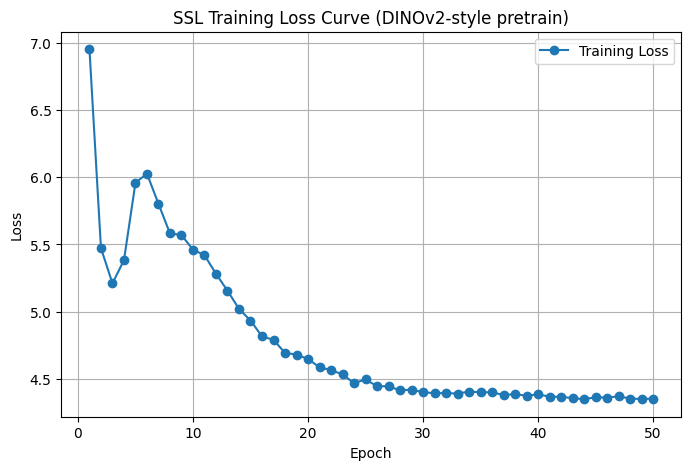

In [9]:
# =============================
# Plot training loss curves
# =============================

plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, marker="o", label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SSL Training Loss Curve (DINOv2-style pretrain)")
plt.legend()
plt.grid(True)
plt.show()

#  Detector fine-tuning (YOLOv12s, init with SSL backbone)

In [10]:
det = YOLO("yolo12s.pt")  
missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
print("Loaded backbone with missing:", len(missing), " unexpected:", len(unexpected))

det.train(
    data=str(DATA),
    epochs=50,                   
    imgsz=640,
    batch=8,
    optimizer="AdamW",            
    lr0=5e-4,                     
    lrf=1e-5,
    weight_decay=0.05,
    cos_lr=True,                  
    mosaic=1.0,
    mixup=0.2,                    
    copy_paste=0.2,               
    auto_augment="randaugment",
    close_mosaic=15,              
    dropout=0.1,                  
    patience=30,
    save_period=5,
    device=0 if device=="cuda" else "cpu",
    project=str(WORK),
    name="ssl_yolov12s_dinov2",
    verbose=True,
)


Loaded backbone with missing: 0  unexpected: 0
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=15, cls=0.5, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/plastic_coco_ssl_yolov12_dinov2/data_plastic_coco.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=1e-05, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ssl_yolov12s_dinov2, nbs=64, nms=False, opset=None, op

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        742      23015      0.559      0.435      0.447      0.208
Speed: 0.1ms preprocess, 7.7ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /kaggle/working/plastic_coco_ssl_yolov12_dinov2/ssl_yolov12s_dinov2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7801bd662fd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Evaluate and visualize one image

Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3919.6±705.3 MB/s, size: 513.2 KB)
val: Scanning /kaggle/working/plastic_coco_ssl_yolov12_dinov2/yolo_split/valid/labels.cache... 742 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 742/742 1303255.3it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 93/93 7.5it/s 12.5s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        742      23015       0.56      0.437      0.448       0.21
Speed: 0.2ms preprocess, 7.4ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val

Validation metrics
 Precision (mP) : 0.5603
 Recall    (mR) : 0.4366
 mAP@0.50      : 0.4484
 mAP@0.50-0.95 : 0.2097


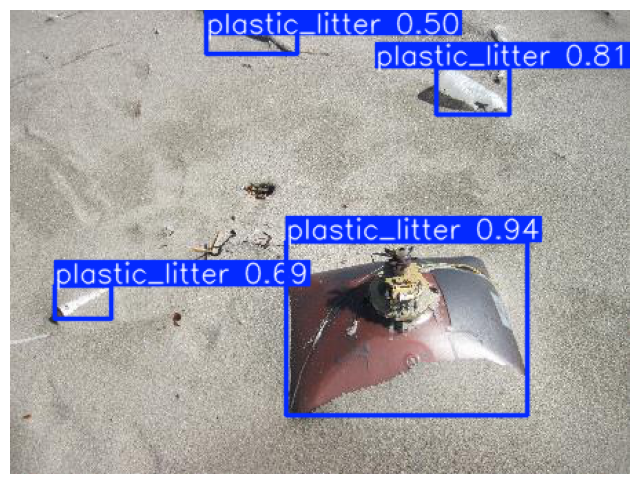

In [11]:
best_pt = WORK / "ssl_yolov12s_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=8,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")

# visualize a random test image
test_imgs = list((SPLIT/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")

# PCA of SSL-pretrained YOLOv12 backbone features (robust encoder)

PCA Feature matrix: (1000, 32)


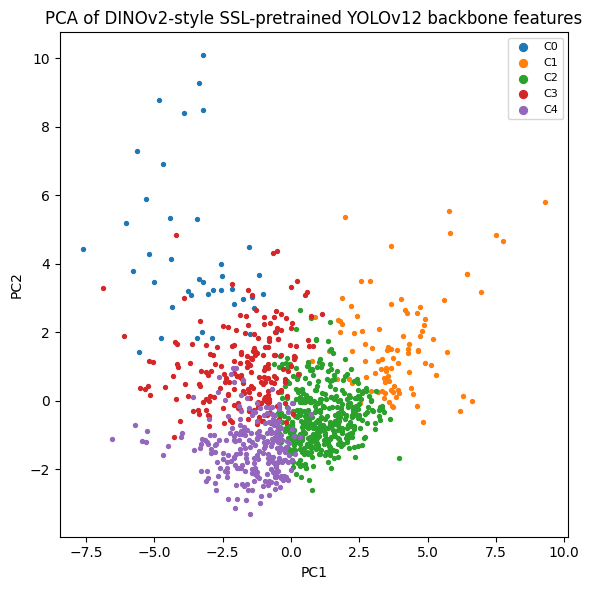

In [12]:
det_pca = YOLO("yolo12s.pt")
det_pca.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
bb = det_pca.model.model[0].to(device).eval()

class BBEnc(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

enc_pca = BBEnc(bb).to(device)
tfm_pca = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# sample images for PCA
IMG_DIRS = [SPLIT/"train/images", SPLIT/"valid/images"]
files=[]
for d in IMG_DIRS:
    if d.exists(): files += list(d.glob("*.*"))
random.shuffle(files)
files = files[:1000] if len(files)>1000 else files

feats=[]
with torch.no_grad():
    for p in files:
        try:
            img = Image.open(p).convert("RGB")
        except:
            continue
        x = tfm_pca(img).unsqueeze(0).to(device)
        z = enc_pca(x)
        feats.append(z.squeeze(0).cpu().numpy())
feats = np.stack(feats, axis=0)
print("PCA Feature matrix:", feats.shape)

pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(feats)

k = 5
lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(feats)

plt.figure(figsize=(6,6))
for i in range(k):
    m = (lab==i)
    plt.scatter(xy[m,0], xy[m,1], s=8, label=f"C{i}")
plt.title("PCA of DINOv2-style SSL-pretrained YOLOv12 backbone features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


# Save YOLOv12 Model Result 

In [13]:
metrics = det.val(data=str(DATA), split="val")

results_dict = {
    "Method": "YOLOv12-SSL",
    "Backbone": "DINOv2",
    "Parameters (M)": round(sum(p.numel() for p in det.model.parameters())/1e6, 2),
    "Precision": metrics.results_dict["metrics/precision(B)"],
    "Recall": metrics.results_dict["metrics/recall(B)"],
    "F1": (2 * metrics.results_dict["metrics/precision(B)"] * metrics.results_dict["metrics/recall(B)"]) /
          (metrics.results_dict["metrics/precision(B)"] + metrics.results_dict["metrics/recall(B)"] + 1e-9),
    "mAP@0.5": metrics.results_dict["metrics/mAP50(B)"],
    "mAP@0.95": metrics.results_dict["metrics/mAP50-95(B)"],
}

with open("results_yolov12.json", "w") as f:
    json.dump(results_dict, f, indent=4)


Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3665.9±372.8 MB/s, size: 2153.7 KB)
val: Scanning /kaggle/working/plastic_coco_ssl_yolov12_dinov2/yolo_split/valid/labels.cache... 742 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 742/742 1591904.6it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 93/93 7.4it/s 12.5s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        742      23015       0.56      0.437      0.448       0.21
Speed: 0.3ms preprocess, 8.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/plastic_coco_ssl_yolov12_dinov2/ssl_yolov12s_dinov22


# **Ablation Study (YOLOv10, YOLOv11, YOLOv12)**

In [14]:

results = [
    {
        "Method": "YOLOv10-SSL",
        "Backbone": "DINOv2",
        "Parameters (M)": 7.22,
        "Precision": 0.4627184238449965,
        "Recall": 0.3515967847056268,
        "F1": 0.3995757616703149,
        "mAP@0.5": 0.33476025853450153,
        "mAP@0.95": 0.3515967847056268,
    },
    {
        "Method": "YOLOv11-SSL",
        "Backbone": "DINOv2",
        "Parameters (M)": 9.41,
        "Precision": 0.5481210851221188,
        "Recall": 0.4326743428199001,
        "F1": 0.48360325363009665,
        "mAP@0.5": 0.4375596160330404,
        "mAP@0.95": 0.2037749837084626,
    }
]

results.append(results_dict)

title = "<h2><b>Ablation Study of YOLOv10, YOLOv11-SSL, and YOLOv12-SSL (DINOv2 Backbone)</b></h2>"
display(HTML(title))
df = pd.DataFrame(results)
display(df)


,Method,Backbone,Parameters (M),Precision,Recall,F1,mAP@0.5,mAP@0.95
0,YOLOv10-SSL,DINOv2,7.22,0.462718,0.351597,0.399576,0.334760,0.351597
1,YOLOv11-SSL,DINOv2,9.41,0.548121,0.432674,0.483603,0.437560,0.203775
2,YOLOv12-SSL,DINOv2,9.23,0.560260,0.436628,0.490778,0.448408,0.209692
